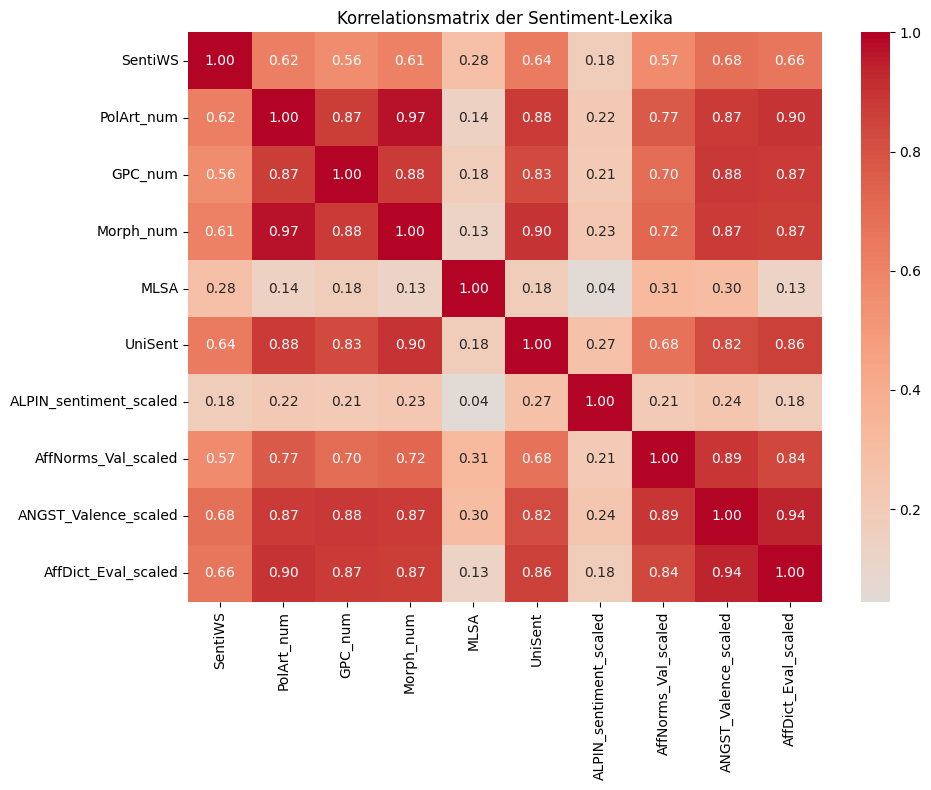

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker
import krippendorff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df = pd.read_csv("sentiment_lexika_scaled_final.csv")

# columns
scaled_cols = [
    'SentiWS',
    'PolArt_num',
    'GPC_num',
    'Morph_num',
    'MLSA',
    'UniSent',
    'ALPIN_sentiment_scaled',
    'AffNorms_Val_scaled',
    'ANGST_Valence_scaled',
    'AffDict_Eval_scaled'
]


# Correlation matrix
correlation_matrix = df[scaled_cols].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Korrelationsmatrix der Sentiment-Lexika")
plt.tight_layout()
plt.savefig("korrelation_heatmap.png")
plt.show()

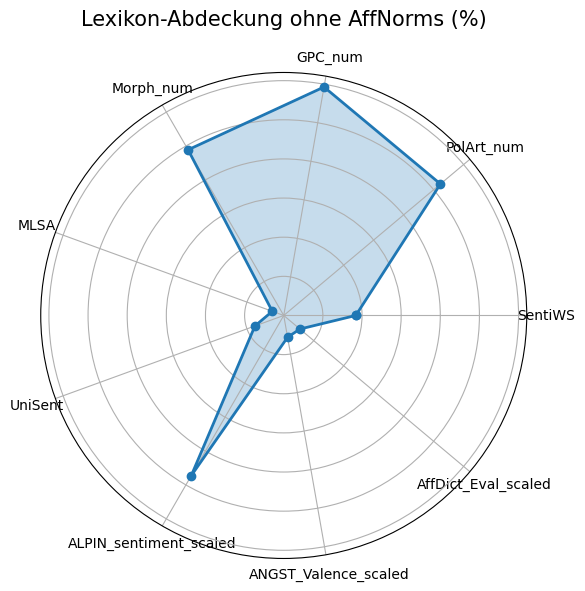

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("sentiment_lexika_scaled_final.csv")

scaled_cols = [
    'SentiWS',
    'PolArt_num',
    'GPC_num',
    'Morph_num',
    'MLSA',
    'UniSent',
    'ALPIN_sentiment_scaled',
    #'AffNorms_Val_scaled',
    'ANGST_Valence_scaled',
    'AffDict_Eval_scaled'
]

# coverage per lexicon
coverage = df[scaled_cols].notnull().mean() * 100

# Radarplot
def plot_radar(values, labels):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    values = values.tolist()
    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, 'o-', linewidth=2, label='Abdeckung')
    ax.fill(angles, values, alpha=0.25)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title("Lexikon-Abdeckung ohne AffNorms (%)", y=1.08, fontsize=15)
    plt.tight_layout()
    plt.savefig("abdeckung_ohne_AffNorms.png")
    plt.show()

plot_radar(coverage.values, coverage.index)

In [ ]:
import numpy as np
import pandas as pd
import krippendorff

df = pd.read_csv("sentiment_lexika_scaled_final.csv")
cols = [
    'SentiWS','PolArt_num','GPC_num','Morph_num','MLSA','UniSent',
    'ALPIN_sentiment_scaled','AffNorms_Val_scaled','ANGST_Valence_scaled','AffDict_Eval_scaled'
]

# Only items/words with >= 4 ratings
mask = df[cols].notna().sum(axis=1) >= 4
df_use = df.loc[mask, cols]

# round to 2 decimal places
df_q = df_use.round(2)

# Rater-Item-Matrix (raters x items)
ratings = df_q.to_numpy(dtype=np.float32).T  # shape: (10, n_items)

# Value domain from -1.0 to 1.0 in steps of 0.01
value_domain = np.round(np.linspace(-1.0, 1.0, 201), 2).astype(np.float32)

alpha = krippendorff.alpha(
    reliability_data=ratings,
    level_of_measurement='interval',
    value_domain=value_domain
)

print(f"Krippendorff's Alpha (intervallskaliert, >=4 Rater): {alpha:.3f}")
print(f"Anzahl Wörter (Items): {ratings.shape[1]}")

Krippendorff's Alpha (intervallskaliert, >=4 Rater): 0.601
Anzahl Wörter (Items): 4375


Wörter mit Polaritätswerten in 1 Lexika: 331390 Wörter (93.74%)
Wörter mit Polaritätswerten in 2 Lexika: 10756 Wörter (3.04%)
Wörter mit Polaritätswerten in 3 Lexika: 5125 Wörter (1.45%)
Wörter mit Polaritätswerten in 4 Lexika: 2249 Wörter (0.64%)
Wörter mit Polaritätswerten in 5 Lexika: 1219 Wörter (0.34%)
Wörter mit Polaritätswerten in 6 Lexika: 574 Wörter (0.16%)
Wörter mit Polaritätswerten in 7 Lexika: 236 Wörter (0.07%)
Wörter mit Polaritätswerten in 8 Lexika: 74 Wörter (0.02%)
Wörter mit Polaritätswerten in 9 Lexika: 19 Wörter (0.01%)
Wörter mit Polaritätswerten in 10 Lexika: 4 Wörter (0.00%)


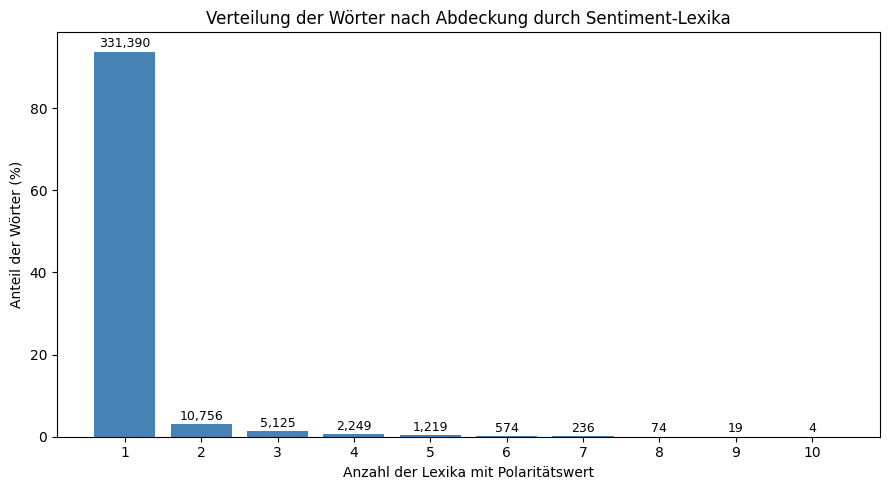

In [ ]:
# availability distribution
available_counts = df[scaled_cols].notnull().sum(axis=1)
distribution = available_counts.value_counts().sort_index()
total_words = len(df)

# min > 0 
distribution = distribution[distribution.index > 0]

for k, v in distribution.items():
    pct = 100 * v / total_words
    print(f"Wörter mit Polaritätswerten in {k} Lexika: {v} Wörter ({pct:.2f}%)")

import matplotlib.pyplot as plt

# data preparation
x = distribution.index
y_abs = distribution.values
y_pct = 100 * y_abs / total_words

plt.figure(figsize=(9,5))
bars = plt.bar(x, y_pct, color="steelblue")

# absolute numbers on top of bars
for bar, abs_val in zip(bars, y_abs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f"{abs_val:,}",
             ha='center', va='bottom', fontsize=9)

plt.xticks(x)
plt.xlabel("Anzahl der Lexika mit Polaritätswert")
plt.ylabel("Anteil der Wörter (%)")
plt.title("Verteilung der Wörter nach Abdeckung durch Sentiment-Lexika")
plt.tight_layout()
plt.show()


In [ ]:
# Scatterplot 
sns.pairplot(df[scaled_cols], corner=True, plot_kws={"s": 10, "alpha": 0.5})
plt.suptitle("Scatterplot-Matrix der Lexika", y=1.02)
plt.savefig("scatterplot_matrix.png")
plt.show()

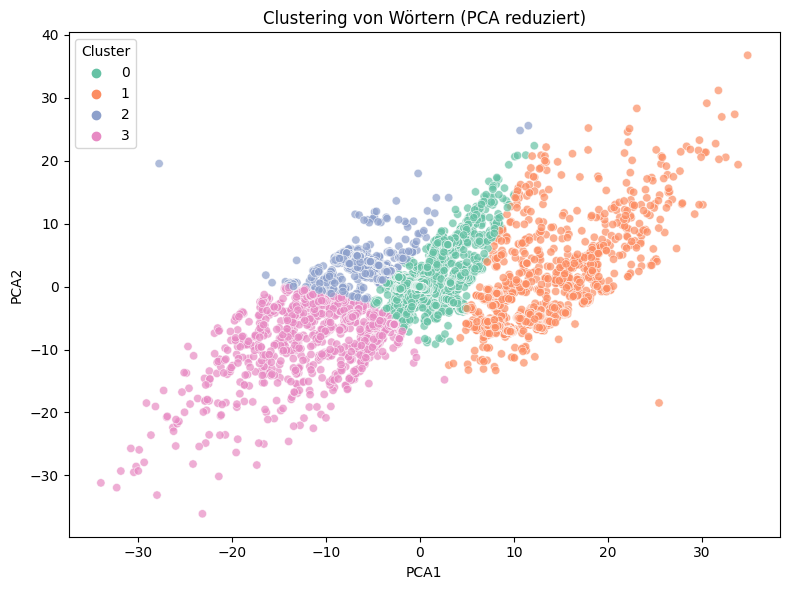

In [ ]:

# Clustering try
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(df[scaled_cols])
scaler = StandardScaler()
scaled_data_std = scaler.fit_transform(scaled_data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data_std)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_result)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
df['Cluster'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", alpha=0.7)
plt.title("Clustering von Wörtern (PCA reduziert)")
plt.tight_layout()
plt.savefig("clustering_pca.png")
plt.show()

In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

# parameter
CSV_PATH = "sentiment_lexika_scaled_final.csv"
COLS = [
    'SentiWS','PolArt_num','GPC_num','Morph_num','MLSA','UniSent',
    'ALPIN_sentiment_scaled','AffNorms_Val_scaled','ANGST_Valence_scaled','AffDict_Eval_scaled'
]
MIN_NON_NULL = 5          # Mindestanzahl an verfügbaren Lexika je Wort
TOP_K = 5                # Anzahl der Wörter für die Top-Listen

# load data, enforce numeric
df = pd.read_csv(CSV_PATH)
X = df[COLS].apply(pd.to_numeric, errors='coerce')

# per word statistics over lexicons
stats = pd.DataFrame({
    'Wort': df['Wort'],
    'n_lexika': X.notna().sum(axis=1),
    'mean': X.mean(axis=1, skipna=True),
    'std': X.std(axis=1, ddof=1, skipna=True),
    'min': X.min(axis=1, skipna=True),
    'max': X.max(axis=1, skipna=True),
})
stats['range'] = stats['max'] - stats['min']
stats['sign_span'] = (stats['min'] < 0) & (stats['max'] > 0)  # Vorzeichenkonflikt

# Filter by minimum coverage
valid = stats[stats['n_lexika'] >= MIN_NON_NULL].copy()

# TOP-K consensus (lowest variance)
top_consensus = valid.sort_values(['std','range']).head(TOP_K)

# TOP-K conflict (highest variance, preferably with sign change)
conflict_signed = valid[valid['sign_span']].sort_values('std', ascending=False).head(TOP_K)
rest = valid[~valid['sign_span']].sort_values('std', ascending=False).head(TOP_K)
top_conflict = pd.concat([conflict_signed, rest]).drop_duplicates('Wort').head(TOP_K)

# result as text output
print("\nTop-K Wörter mit höchstem Konsens (geringste Streuung):")
for _, row in top_consensus.iterrows():
    print(f"{row['Wort']}: std={row['std']:.3f}, mean={row['mean']:.3f}, n={int(row['n_lexika'])}")

print("\nTop-K Wörter mit höchstem Konflikt (größte Streuung):")
for _, row in top_conflict.iterrows():
    print(f"{row['Wort']}: std={row['std']:.3f}, range={row['range']:.3f}, sign_conflict={row['sign_span']}, n={int(row['n_lexika'])}")


Top-K Wörter mit höchstem Konsens (geringste Streuung):
bank: std=0.040, mean=-0.015, n=5
kreis: std=0.057, mean=0.033, n=5
misshandlung: std=0.062, mean=-0.955, n=5
selbstmord: std=0.075, mean=-0.946, n=5
regen: std=0.089, mean=-0.011, n=5

Top-K Wörter mit höchstem Konflikt (größte Streuung):
berauscht: std=0.936, range=2.000, sign_conflict=True, n=5
androhen: std=0.910, range=2.000, sign_conflict=True, n=5
beharrlich: std=0.904, range=2.000, sign_conflict=True, n=6
lasziv: std=0.889, range=2.000, sign_conflict=True, n=5
ethisch: std=0.889, range=2.000, sign_conflict=True, n=5


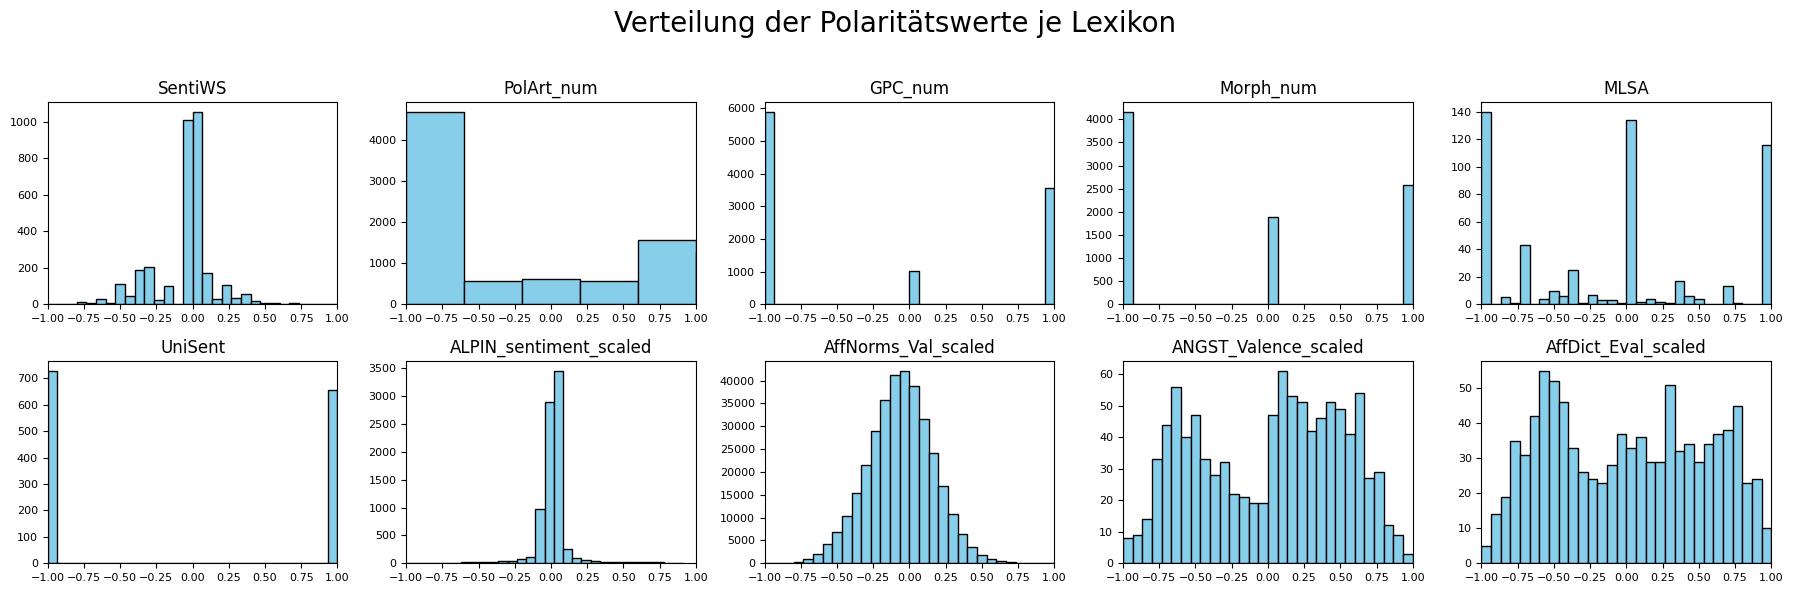

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("sentiment_lexika_scaled_final.csv")

# important columns
scaled_cols = [
    'SentiWS',
    'PolArt_num',
    'GPC_num',
    'Morph_num',
    'MLSA',
    'UniSent',
    'ALPIN_sentiment_scaled',
    'AffNorms_Val_scaled',
    'ANGST_Valence_scaled',
    'AffDict_Eval_scaled'
]

# Plots setup
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6))
axes = axes.flatten()

# creating histograms
for i, col in enumerate(scaled_cols):
    axes[i].hist(df[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    # all on the same scale
    axes[i].set_xlim(-1, 1)  
    # same Y-axis
    axes[i].set_ylim(0, None) 
    axes[i].tick_params(axis='both', which='major', labelsize=8)

# Hide empty axes if necessary
for j in range(len(scaled_cols), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Verteilung der Polaritätswerte je Lexikon", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("lexikon_histogramme.png", dpi=300)
plt.show()

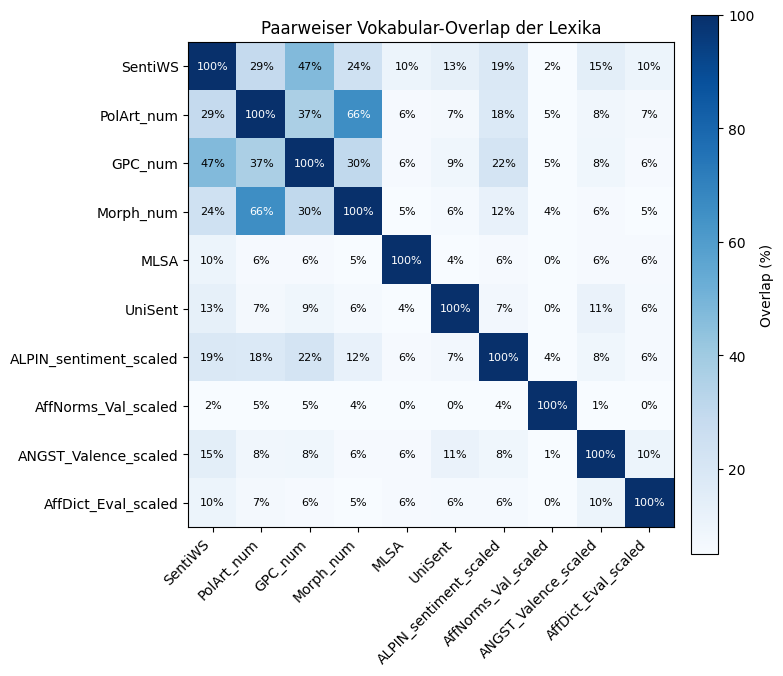

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

lex = scaled_cols
n = len(lex)

# Index sets of all words per lexicon
idx_sets = {c: set(df.index[df[c].notna()]) for c in lex}

# Compute matrix (overlap in %)
M = np.zeros((n, n))
for i, a in enumerate(lex):
    for j, b in enumerate(lex):
        inter = len(idx_sets[a] & idx_sets[b])
        denom = (len(idx_sets[a]) + len(idx_sets[b])) / 2
        M[i, j] = 100 * inter / denom if denom > 0 else 0

# Plot with stronger contrast for small values
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(M, cmap="Blues", vmin=5, vmax=100)  # vmin auf 5 gesetzt

# Axis labels
ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(lex, rotation=45, ha="right")
ax.set_yticklabels(lex)

# Write percentage values into the cells
for i in range(n):
    for j in range(n):
        val = M[i, j]
        ax.text(j, i, f"{val:.0f}%", ha="center", va="center",
                color="black" if val < 50 else "white", fontsize=8)

# Colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.03)
cbar.set_label("Overlap (%)")

ax.set_title("Paarweiser Vokabular-Overlap der Lexika")
plt.tight_layout()
plt.show()
